<a href="https://colab.research.google.com/github/gisandnes/Extreme-Gradient-Boosting-with-XGBoost_DataCamp/blob/master/Regression_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir -p data #Make folders for downloads

#!wget --no-verbose https://raw.githubusercontent.com/gisandnes/Extreme-Gradient-Boosting-with-XGBoost_DataCamp/master/data/chronic_kidney_disease.csv -O ./data/chronic_kidney_disease.csv
#!wget --no-verbose https://raw.githubusercontent.com/gisandnes/Extreme-Gradient-Boosting-with-XGBoost_DataCamp/master/data/ames_unprocessed_data.csv -O ./data/ames_unprocessed_data.csv 
!wget --no-verbose https://raw.githubusercontent.com/gisandnes/Extreme-Gradient-Boosting-with-XGBoost_DataCamp/master/data/ames_housing_trimmed_processed.csv -O ./data/ames_housing_trimmed_processed.csv

2019-01-15 13:01:04 URL:https://raw.githubusercontent.com/gisandnes/Extreme-Gradient-Boosting-with-XGBoost_DataCamp/master/data/ames_housing_trimmed_processed.csv [196754/196754] -> "./data/ames_housing_trimmed_processed.csv" [1]


In [0]:
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb

%matplotlib inline

In [0]:
ames_processed  = pd.read_csv("./data/ames_housing_trimmed_processed.csv")
features = ames_processed.loc[:,"MSSubClass":"PavedDrive_Y"] # Pandas Data Frame
response = ames_processed.loc[:,"SalePrice"]                 # Pandas Series

# Note that we use Pandas Data Frame and Pandas Series in DMatrix, not Numpy arrays

###Evaluating model quality

In [0]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=features, label=response)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

   test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0   142980.433594    1193.791602    141767.531250      429.454591
1   104891.394532    1223.158855    102832.544922      322.469930
2    79478.937500    1601.344539     75872.615235      266.475960
3    62411.920899    2220.150028     57245.652343      273.625086
4    51348.279297    2963.377719     44401.298828      316.423666
4    51348.279297
Name: test-rmse-mean, dtype: float64


### Using L2 regularization in XGBoost

In [0]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=features, label=response)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:linear","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)
    
    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

Best rmse as a function of l2:
    l2          rmse
0    1  52275.357421
1   10  57746.064453
2  100  76624.625000


###Visualizing individual XGBoost trees

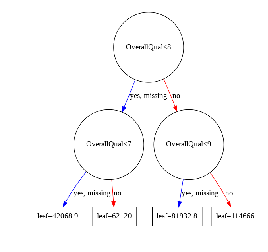

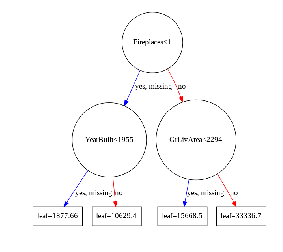

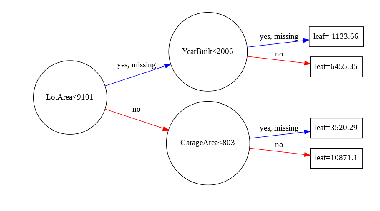

In [0]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=features, label=response)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)


#plt.figure(figsize=(8, 4)) Make bigger???

# Plot the first tree
xgb.plot_tree(xg_reg, num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg, num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg, num_trees=9, rankdir="LR")
plt.show()

###Visualizing feature importances: What features are most important in my dataset

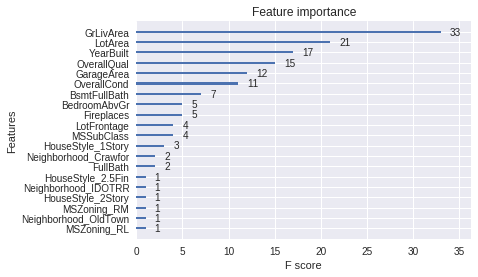

In [0]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=features, label=response)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()

### Calculate folds separately, to compare different methods honestly

In [11]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=features, label=response)

kfold = KFold(n_splits=4, shuffle=True, random_state=123)
folds = kfold.split(housing_dmatrix)

# Create the parameter dictionary: params
params = {"objective":"reg:linear", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, num_boost_round=5, folds=folds, metrics="rmse", as_pandas=True)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

   test-rmse-mean  test-rmse-std  train-rmse-mean  train-rmse-std
0   136073.533854   20847.453786    139216.236979    11003.460718
1   100040.671875   20400.645712    100916.588541     8360.940664
2    75446.850260   20241.439411     74266.667969     6456.598227
3    58972.595052   19278.263295     55884.333333     5242.444592
4    48573.604166   18256.123115     43212.674479     4511.794575
4    48573.604166
Name: test-rmse-mean, dtype: float64


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
